## ETL workflow

### Extract Raw Data

#### Extract data from first API: JSearch
https://rapidapi.com/letscrape-6bRBa3QguO5/api/jsearch/

In [50]:
def api_1_mongo(api_data, collection):
    job_dict = {}
    for i in range(len(api_data["data"])):
            job_dict = api_data["data"][i]
            collection.insert_one(job_dict)

In [51]:
import pymongo
import requests

# connect to mogoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["bigdata"]

url = "https://jsearch.p.rapidapi.com/search"

query_jobs = ["Software Engineer", "Technical Manager", "Data Scientist",  "Researcher", "Cloud Developer"]
collection_list = ["software_engineer","technical_manager", "data_scientist",  "researcher", "cloud_developer"]
headers = {
	"content-type": "application/octet-stream",
	"X-RapidAPI-Key": "5dcca9a446mshc45e979b7c63b61p110313jsn2355dc91241e",
	"X-RapidAPI-Host": "jsearch.p.rapidapi.com"
}

for i in range(len(query_jobs)):
    querystring = {"query":query_jobs[i],"page":"1","num_pages":"20","date_posted":"all"}
    response = requests.get(url, headers=headers, params=querystring)
    data_dict = response.json()
    collection = db[collection_list[i]]
    api_1_mongo(data_dict, collection)



#### Extract data from second API: linked in 
https://rapidapi.com/jaypat87/api/linkedin-jobs-search/


In [63]:
def api_2_mongo(apidata, collection):
   for i, item in enumerate(apidata):
      if isinstance(item, dict):
         collection.insert_one(item)
         

In [64]:
import requests
url = "https://linkedin-jobs-search.p.rapidapi.com/"

headers = {
 "content-type": "application/json",
 "X-RapidAPI-Key": "5dcca9a446mshc45e979b7c63b61p110313jsn2355dc91241e",
 "X-RapidAPI-Host": "linkedin-jobs-search.p.rapidapi.com"
}


for i in range(len(query_jobs)):
    payload = {
		"search_terms":query_jobs[i],
		"location": "United States",
		"page": 1
		}
    response = requests.post(url, json=payload, headers=headers)
    data_dict = response.json()
    collection = db[collection_list[i]]
    api_2_mongo(data_dict, collection)
        


#### Extract data from third API
Indeed, Talent, Snagajob, Careerbuilder and Nexxt

https://rapidapi.com/jaypat87/api/indeed11

This APi is used for get pay for each job

In [17]:
def api_3_mongo(apidata, collection, location):
   try:
      for item in apidata["results"]:
          insert_dict = {"location" :location}
          insert_dict['job_title'] = item['job']['job_title']
          insert_dict['company'] = item['job']['company']
          insert_dict['job_details'] = item['job_details']['link']
          insert_dict['pay'] = item['job_details']['pay']
          collection.insert_one(insert_dict)
   except KeyError:
      print(apidata)

In [18]:
import requests
url = "https://job-board-search-fastapply.p.rapidapi.com/us/snagajob/fetchjobs"
headers =[{
	"content-type": "application/json",
	"X-RapidAPI-Key": "394d899556msh4f0740173b447c1p1e6a45jsnfd1521c2520f",
	"X-RapidAPI-Host": "job-board-search-fastapply.p.rapidapi.com"
},
 {
 "content-type": "application/json",
 "X-RapidAPI-Key": "5dcca9a446mshc45e979b7c63b61p110313jsn2355dc91241e",
 "X-RapidAPI-Host": "job-board-search-fastapply.p.rapidapi.com"
},
{
    'content-type': 'application/json',
    'X-RapidAPI-Key': 'a668dfde94msh4ef920baed52701p11288cjsnd7650a4668cf',
    'X-RapidAPI-Host': 'job-board-search-fastapply.p.rapidapi.com'
  },
  {
	"content-type": "application/json",
	"X-RapidAPI-Key": "84053fe846msh32e4835fd7634fcp161e65jsn2bab6bacf9cb",
	"X-RapidAPI-Host": "job-board-search-fastapply.p.rapidapi.com"
}
] 

pay_collection_list = []

for item in collection_list:
    item =item.strip()+ "_pay"
    pay_collection_list.append(item)
print("new collections: ", pay_collection_list)

locations = ["New York", "California", "Washington", "Texas","Illinois", "Remote"]
header_count = 0
prev_data = None
for i in range(len(query_jobs)):
    for location in locations:
        payload = {
		"keyword": query_jobs[i],
		"location": location,
		"radius": 15,
		"page_number": 1
		} 
        try:
            response = requests.post(url, json=payload, headers=headers[header_count])
        
            if(response.json() == {'message': 'You have exceeded the rate limit per minute for your plan, BASIC, by the API provider'}):
                header_count += 1
                continue
            if(response.json() == prev_data):
                continue
            
            data_dict = response.json()
            collection = db[pay_collection_list[i]]
            api_3_mongo(data_dict, collection, location)
            prev_data = response.json()
        except IndexError:
            print("end")

new collections:  ['software_engineer_pay', 'technical_manager_pay', 'data_scientist_pay', 'researcher_pay', 'cloud_developer_pay']
{'message': 'You have exceeded the MONTHLY quota for Requests on your current plan, BASIC. Upgrade your plan at https://rapidapi.com/fastapply/api/job-board-search-fastapply'}


### Transform Raw Data

#### Unify fields name from different APIs

In [65]:
import pymongo

# Connect to MongoDB
client = pymongo.MongoClient('mongodb://localhost:27017')
db = client['bigdata']
collection = db['software_engineer']

# Update the field name
collection.update_many({}, {"$rename": {"job_url": "job_apply_link"}})


#### Clean Wrong Data(Title doeen't match with query's title)

In [19]:
def clean_title_wrong_data(field, value, collection, colname):
    query = {field : {"$exists":True}}
    value_split = value.split()
    documents = collection.find(query)
    clean_count = 0
    for doc in documents:
        title = doc[field]
        lower_title =title.lower()
        for item in value_split:
            if item in lower_title:
                continue
            else:
                clean_count += 1
                collection.find_one_and_delete({field : title})
                
    print(colname,"collection cleaned data :", clean_count)
    
    

In [20]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["bigdata"]

for i in range(len(query_jobs)):
    clean_title_wrong_data(field="job_title", value = query_jobs[i].lower(), collection=db[pay_collection_list[i]], colname = pay_collection_list[i])

software_engineer_pay collection cleaned data : 54
technical_manager_pay collection cleaned data : 184
data_scientist_pay collection cleaned data : 121
researcher_pay collection cleaned data : 146
cloud_developer_pay collection cleaned data : 271


#### Clean Data Without "pay_hourly"

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def clean_pay_noexist(collection, col_name):
    ori_doc = collection.count_documents({})
    query = {"pay.pay_hourly" : {"$exists": False}}
    collection.delete_many(query)
    cur_doc = collection.count_documents({})
    print(col_name , "collection cleaned data: ", ori_doc - cur_doc)

In [24]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["bigdata"]

for i in range(len(pay_collection_list)):
   clean_pay_noexist(db[pay_collection_list[i]],pay_collection_list[i])

software_engineer_pay collection cleaned data:  0
technical_manager_pay collection cleaned data:  0
data_scientist_pay collection cleaned data:  0
researcher_pay collection cleaned data:  0
cloud_developer_pay collection cleaned data:  0


#### Clean Duplicate Data

In [52]:
def clean_duplicate(collection, col_name):
    print(col_name, "before clean duplicate:" ,collection.count_documents({}))
    if "pay" in col_name:
    # Find duplicatedata
        deleteData = collection.aggregate([
        {
            "$group": {
            '_id': { 'field1': "$job_details"},
            'count': { "$sum": 1 },
            'uniqueIds': { "$addToSet": "$_id" }
            }
        },
        {
            "$match": {
            'count': { "$gt": 1 }
            }
        }
        ])
    else:
        deleteData = collection.aggregate([
        {
            "$group": {
            '_id': { 'field1': "$job_apply_link"},
            'count': { "$sum": 1 },
            'uniqueIds': { "$addToSet": "$_id" }
            }
        },
        {
            "$match": {
            'count': { "$gt": 1 }
            }
        }
        ])
    first=True
    for d in deleteData:
        first=True
        for did in d['uniqueIds']:
            if not first:    # don't delete first
                collection.delete_one({'_id':did});
            first=False
    print(col_name, "after clean duplicate:" ,collection.count_documents({}))

In [53]:
for item in pay_collection_list:
    collection = db[item]
    clean_duplicate(collection, item)

for item in collection_list:
    collection = db[item]
    clean_duplicate(collection, item)


software_engineer_pay before clean duplicate: 66
software_engineer_pay after clean duplicate: 66
technical_manager_pay before clean duplicate: 1
technical_manager_pay after clean duplicate: 1
data_scientist_pay before clean duplicate: 39
data_scientist_pay after clean duplicate: 39
researcher_pay before clean duplicate: 4
researcher_pay after clean duplicate: 4
cloud_developer_pay before clean duplicate: 0
cloud_developer_pay after clean duplicate: 0
software_engineer before clean duplicate: 369
software_engineer after clean duplicate: 232
technical_manager before clean duplicate: 347
technical_manager after clean duplicate: 228
data_scientist before clean duplicate: 366
data_scientist after clean duplicate: 249
researcher before clean duplicate: 370
researcher after clean duplicate: 227
cloud_developer before clean duplicate: 369
cloud_developer after clean duplicate: 217


### Data Analyse (Plot salary of different jobs and locations)
A simple example using our data

In [57]:
def plot_salary(pay_collection, job_title) :
    query = {"pay.pay_hourly" : {"$gt": 0}}
    documents = pay_collection.find(query)
    job_name = []
    salary = []
    for doc in documents:
        try:
            pay_per_year = doc['pay']['pay_yearly']
            salary.append(pay_per_year)
            job_name.append(job_title)
        except KeyError:
            continue
    return salary, job_name

[184000.0, 124000.0, 124000.0, 124000.0, 124000.0, 122000.0, 122000.0, 122000.0, 122000.0, 100000.0, 100000.0, 100000.0, 100000.0, 102000.0, 102000.0, 36000.0, 102000.0, 102000.0, 102000.0, 102000.0, 102000.0, 102000.0, 102000.0, 102000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 124000.0, 124000.0, 124000.0, 124000.0, 122000.0, 122000.0, 122000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 120000.0, 146000.0, 146000.0, 120000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 120000.0, 146000.0, 146000.0, 146000.0, 146000.0, 146000.0, 44000.0, 122000.0, 122000.0, 122000.0, 122000.0, 122000.0, 124000.0, 124000.0, 124000.0, 96000.0, 98000.0, 122000, 122000.0, 114000.0, 98000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0, 96000.0

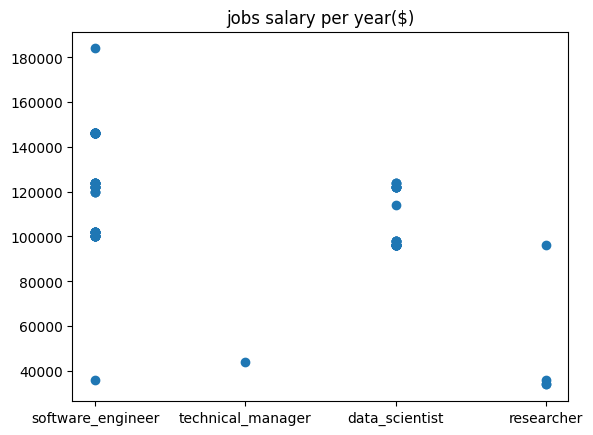

In [62]:
import matplotlib.pyplot as plt
import numpy as np
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["bigdata"]
salary_list = []
job_list = []
for item in pay_collection_list:
    collection = db[item]
    salary, job_name = plot_salary(collection, item[0:-4])
    for data in salary:
        salary_list.append(data)
    for name in job_name:
        job_list.append(name)


print(salary_list)
y = np.array(salary_list)
x = np.array(job_list)
plt.scatter(x, y)
plt.title("jobs salary per year($)")
plt.show()